In [1]:
%load_ext autoreload
%autoreload 2

In [174]:
from cptsolver.fields import *
from cptsolver.utils import *
from cptsolver.plot import *
from cptsolver.integrators import *
from cptsolver.solver import *
from cptsolver.analyzer import *
from cptsolver.young import *

from matplotlib import pyplot as plt

from datetime import datetime

In [3]:
parmod, ut, v_sw = get_txx_params('data/qindenton_03-26-2008', 'data/omni_03-26-2008', datetime(2008, 3, 26, 11, 19))

In [4]:
b_field = t04(parmod, ut, v_sw)

Load IGRF coefficients ...


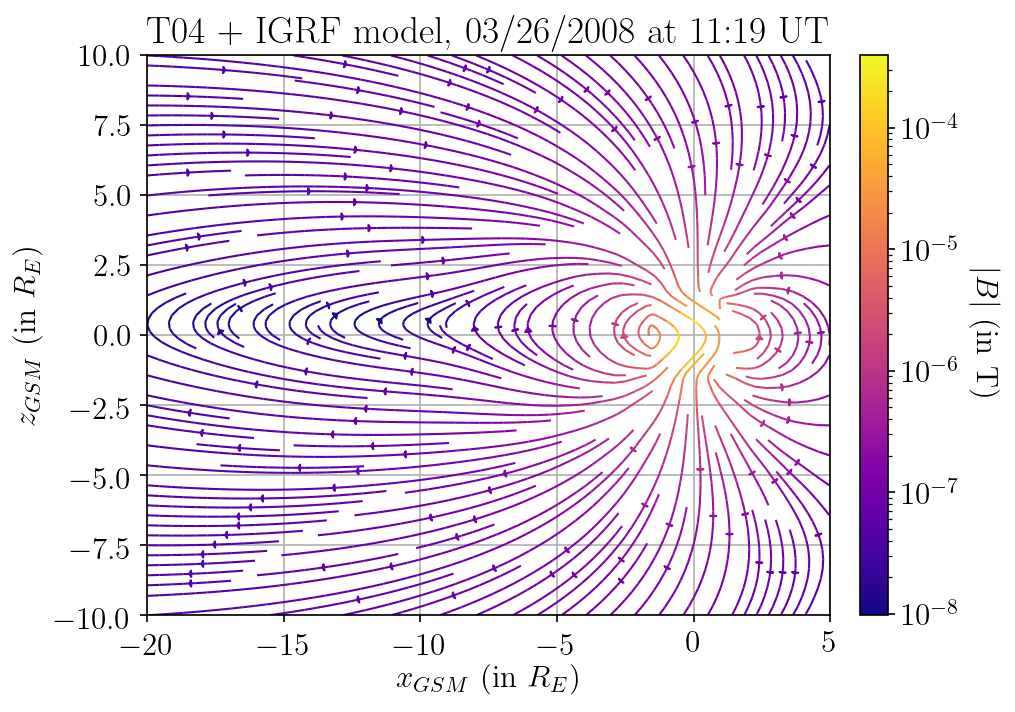

In [5]:
format_plots()
plot_field(b_field, np.array([1., 0., 0.]), np.array([0., 0., 1.]), [-20, 5], [-10, 10], size=(7, 5), labels=('$x_{GSM}$ (in $R_E$)', '$z_{GSM}$ (in $R_E$)', '$|B|$ (in T)'), title='T04 + IGRF model, 03/26/2008 at 11:19 UT')

In [109]:
rr = field_line(b_field, np.array([-10 * Re, 0., 0.]))

In [110]:
bv, bm, brm = b_along_path(b_field, rr)

In [111]:
cs_ind = bm.argmin()

In [149]:
r_eq = np.linalg.norm(rr[cs_ind])
R_c = flc(b_field, rr[cs_ind], 0, 1)

b_plus_h = 0
b_s0 = bm[cs_ind]
b_minus_h = 0

h = 0
stepsize = 10
steps = 1e4

r_plus_h = np.copy(rr[cs_ind])
b_plus_h = b_field(r_plus_h)
b_plus_h /= np.linalg.norm(b_plus_h)

r_minus_h = np.copy(rr[cs_ind])
b_minus_h = b_field(r_minus_h)
b_minus_h /= np.linalg.norm(b_minus_h)

for i in range(int(steps)):
    r_old = np.copy(r_plus_h)
    r_plus_h += b_plus_h * stepsize
    
    h_add = np.linalg.norm(r_plus_h - r_old)
    
    b_plus_h = b_field(r_plus_h)
    b_plus_h /= np.linalg.norm(b_plus_h)
    
    r_old = np.copy(r_minus_h)
    r_minus_h -= b_minus_h * stepsize
    
    h_add += np.linalg.norm(r_minus_h - r_old)
    
    b_minus_h = b_field(r_minus_h)
    b_minus_h /= np.linalg.norm(b_minus_h)
    
    h += h_add * 0.5
    
R_c_plus_h = flc(b_field, r_plus_h, 0, 1)
R_c_minus_h = flc(b_field, r_minus_h, 0, 1)

d2_Rc_ds2 = (R_c_plus_h - 2 * R_c + R_c_minus_h) / h**2
d2_B_ds2 = (np.linalg.norm(b_field(r_plus_h)) - 2 * b_s0 + np.linalg.norm(b_field(r_minus_h))) / h**2

zeta1_t04 = R_c * d2_Rc_ds2
zeta2_t04 = (R_c**2 / b_s0) * d2_B_ds2

In [179]:
z2

1.0138387292988147

In [155]:
(R_c / zeta2_t04) / Re

0.14988158746360847

In [190]:
b0x, sigma, L_cs = harris_params_from_txx(b_field, 10, 0.14988158746360847 * Re)
b_field_h = harris_cs_model(b0x, sigma, L_cs)

In [191]:
np.degrees(np.arcsin(np.sqrt(b0x / bm[1226])))

0.6510380234854473

In [192]:
np.degrees(np.arcsin(np.sqrt(b0x / bm[293])))

0.6961745144505138

In [193]:
zsT = (rr[:, 2] - rr[cs_ind, 2]) / Re
flcT = np.zeros(len(bm))

for i in range(len(flcT)):
    flcT[i] = flc(b_field, rr[i], eps=10) / Re
    
N = 200
zs = np.linspace(-2, 2, N)

bm0 = np.zeros(N)
bm1 = np.zeros(N)

flc0 = np.zeros(N)
flc1 = np.zeros(N)

for i in range(N):
    bm0[i] = np.linalg.norm(b_field_h(np.array([0., 0., zs[i] * Re])))
    flc0[i] = flc(b_field_h, np.array([0., 0., zs[i] * Re]), eps=10) / Re

In [194]:
bh_v = np.zeros((300, 3))
zs_h = np.linspace(-2, 2, 300)

for i in range(300):
    bh_v[i] = b_field_h(np.array([0., 0., zs_h[i] * Re]))

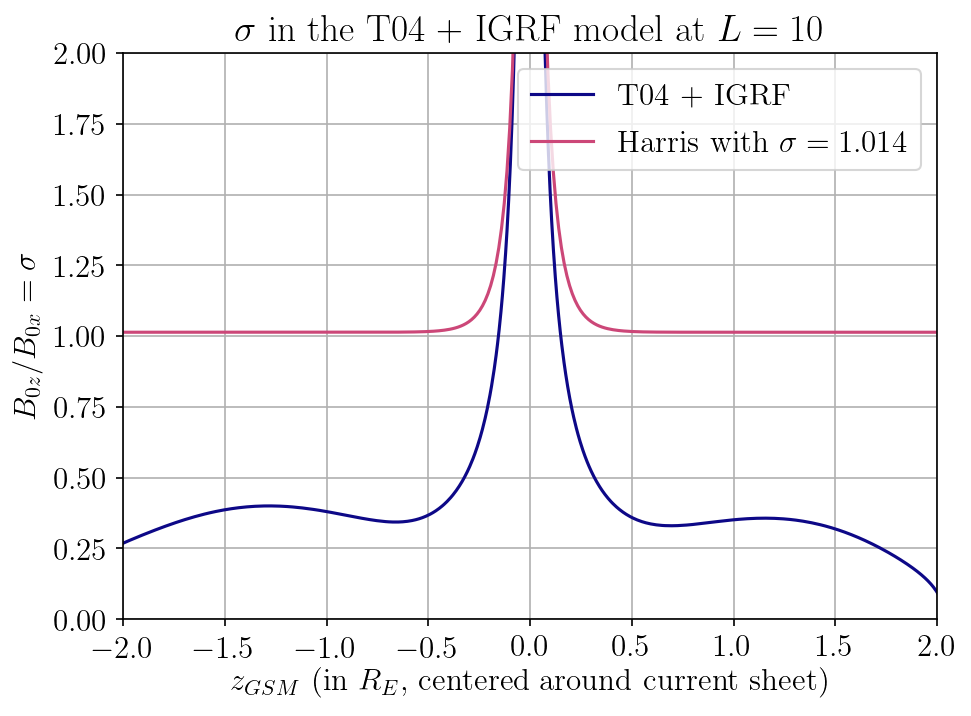

In [212]:
pad = 480
format_plots()
plt.figure(figsize=(7, 5))
plt.plot((rr[:, 2][pad:-pad] - rr[cs_ind, 2]) / Re, np.abs(bv[:, 2][pad:-pad] / bv[:, 0][pad:-pad]), label='T04 + IGRF')
plt.plot(zs_h, np.abs(bh_v[:, 2] / bh_v[:, 0]), c='C7', label='Harris with $\sigma = 1.014$')
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel(r'$B_{0z}/B_{0x} = \sigma$')
plt.title('$\sigma$ in the T04 + IGRF model at $L = 10$')
plt.ylim([0, 2])
plt.xlim([-2, 2])
plt.legend()
plt.grid()
plt.show()

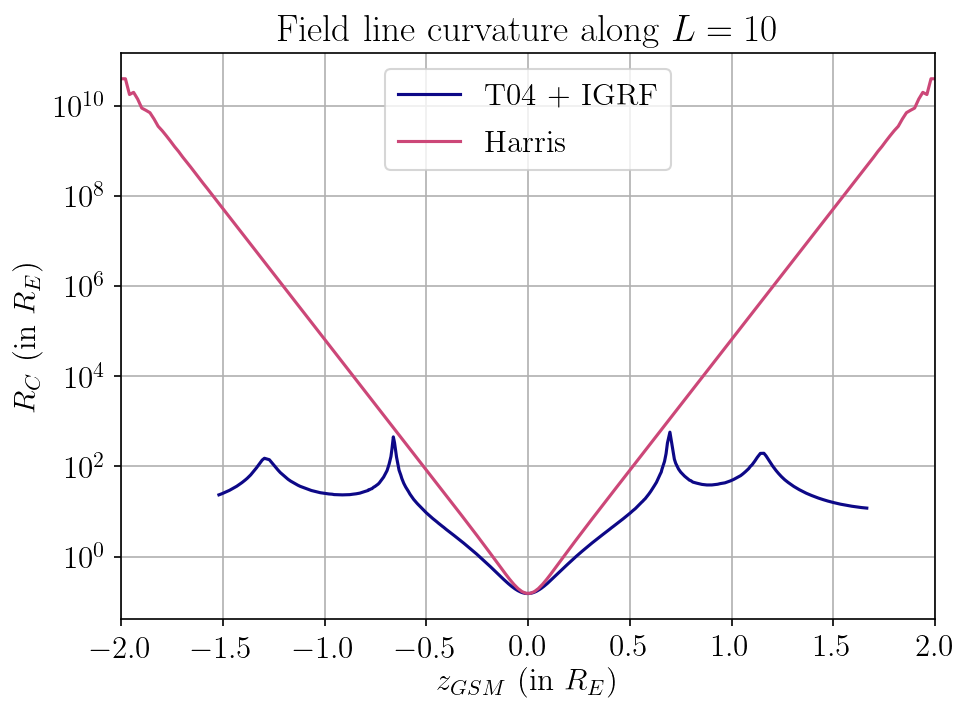

In [196]:
format_plots()
plt.figure(figsize=(7, 5))

#plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    

#plt.semilogy(zs, bm0, label=r'Harris', c='C7')
plt.semilogy(zs, flc0, label=r'Harris', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$)')
#plt.ylabel('$|B|$ (in T)')
#plt.title('Magnetic field strength along $L=10$')
plt.ylabel('$R_C$ (in $R_E$)')
plt.title('Field line curvature along $L=10$')

plt.legend()
plt.grid()
plt.show()

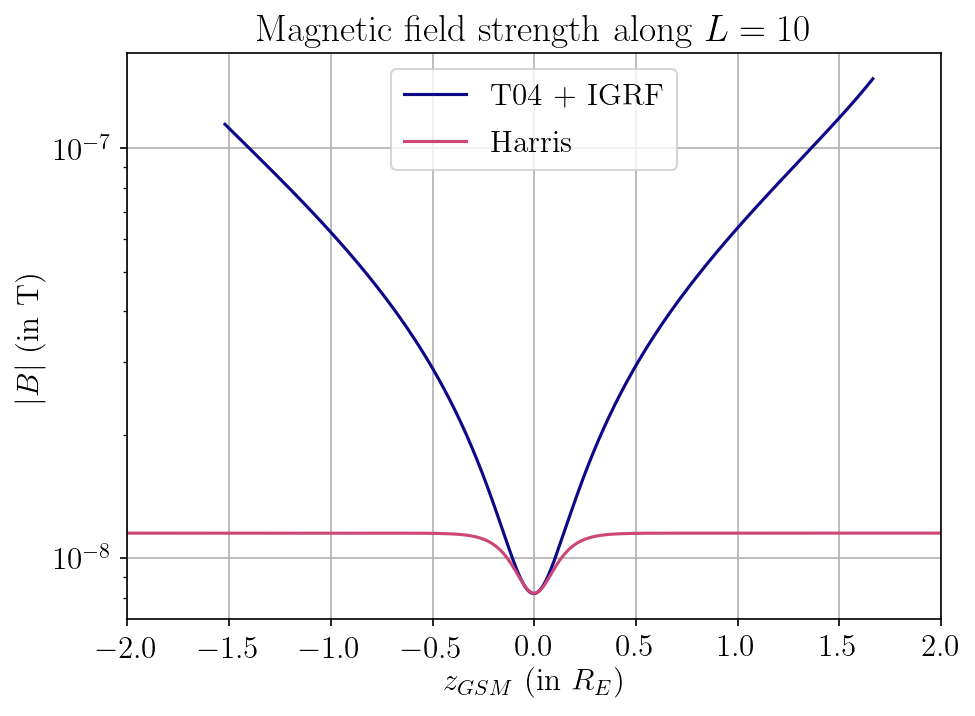

In [197]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
#plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    

plt.semilogy(zs, bm0, label=r'Harris', c='C7')
#plt.semilogy(zs, flc0, label=r'Harris', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$)')
plt.ylabel('$|B|$ (in T)')
plt.title('Magnetic field strength along $L=10$')
#plt.ylabel('$R_C$ (in $R_E$)')
#plt.title('Field line curvature along $L=10$')

plt.legend()
plt.grid()
plt.show()

In [173]:
T_alpha = normalized_bounce_time(b_field, 10)

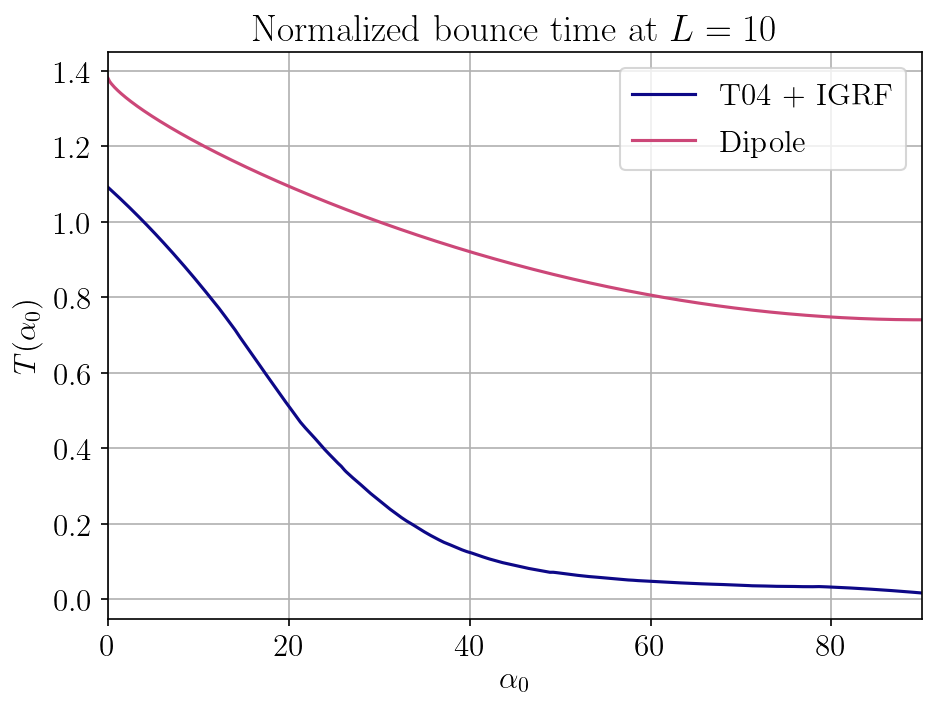

In [175]:
plt.figure(figsize=(7, 5))
alpha_eqs = np.radians(np.linspace(0, 90, 500))
plt.plot(np.degrees(alpha_eqs), T_alpha(alpha_eqs), label='T04 + IGRF')
plt.plot(np.degrees(alpha_eqs), T_dipole(alpha_eqs), label='Dipole', c='C7')
plt.xlim([0, 90])
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$T(\alpha_0)$')
plt.legend()
plt.title('Normalized bounce time at $L = 10$')
plt.grid()
plt.show()

8866379.409495072
4780.938076047628
360.84867114684937
123.3481749101849


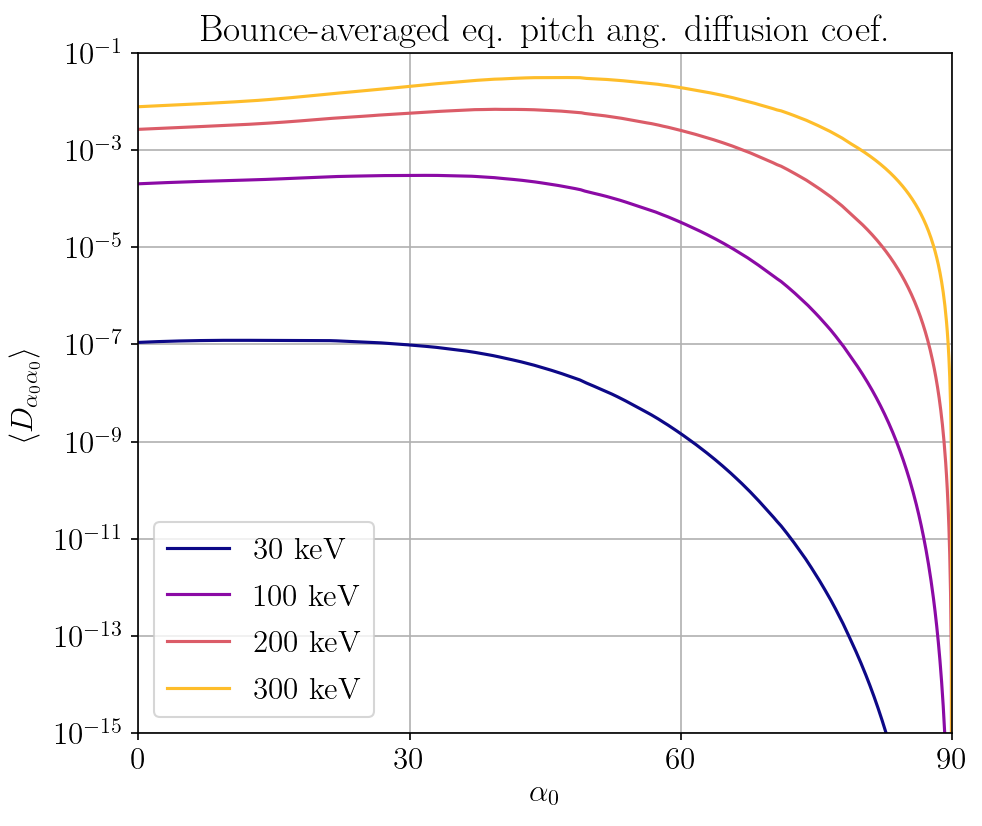

In [199]:
plt.figure(figsize=(7, 6))
z1 = zeta_1(sigma)
z2 = zeta_2(sigma)
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, 1000))

eps = epsilon(3e4, -sp.e, sp.m_e, b0x, sigma, L_cs)
D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
plt.semilogy(np.degrees(alpha_eqs), D_aas, c='C0', label='$30$ keV')
print(1 / D_aas[14])

eps = epsilon(1e5, -sp.e, sp.m_e, b0x, sigma, L_cs)
D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
plt.semilogy(np.degrees(alpha_eqs), D_aas, c='C4', label='$100$ keV')
print(1 / D_aas[14])

eps = epsilon(2e5, -sp.e, sp.m_e, b0x, sigma, L_cs)
D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
plt.semilogy(np.degrees(alpha_eqs), D_aas, c='C8', label='$200$ keV')
print(1 / D_aas[14])

eps = epsilon(3e5, -sp.e, sp.m_e, b0x, sigma, L_cs)
D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
plt.semilogy(np.degrees(alpha_eqs), D_aas, c='C12', label='$300$ keV')
print(1 / D_aas[14])

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.ylim([1e-15, 1e-1])
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')
plt.legend()
plt.grid()
plt.show()

In [177]:
z1 = zeta1_t04
z2 = zeta2_t04

In [21]:
tau_P = (1 / D_aas[2])

In [203]:
B_g = np.linalg.norm(b_field_h(np.array([0, 0, 5 * Re])))

In [204]:
B_0 = np.linalg.norm(b_field_h(np.array([0, 0, 0 * Re])))

In [205]:
np.degrees(np.arcsin(np.sqrt(B_0/B_g)))

57.54047017974537

In [206]:
gamma = eV_to_J(3e4) / (sp.m_e * sp.c**2) + 1
v = sp.c * np.sqrt(1 - 1 / gamma**2)
(gamma * sp.m_e * v / (np.abs(-sp.e) * B_0)) / Re

0.0113630037692448

In [207]:
def kappa_h(E):
    gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1
    v = sp.c * np.sqrt(1 - 1 / gamma**2)
    return np.sqrt(np.abs(-sp.e) * sigma**2 * L_cs * b0x / (gamma * sp.m_e * v))

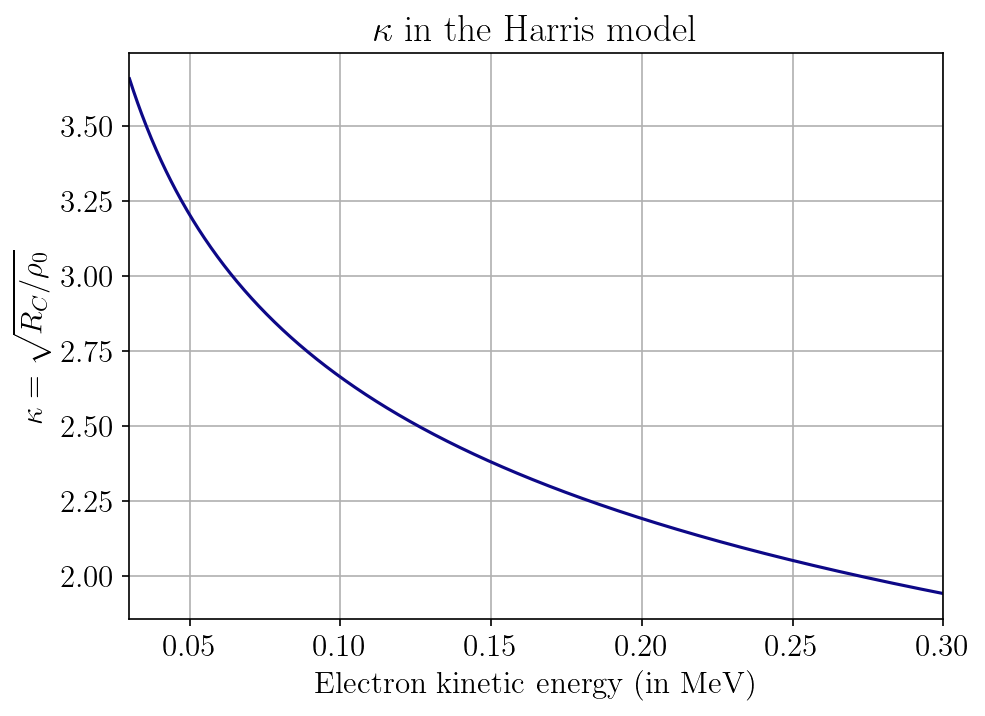

In [210]:
energies = np.linspace(30e3, 300e3, 1000)
plt.figure(figsize=(7, 5))
plt.plot(energies * 1e-6, kappa_h(energies))
plt.grid()
plt.xlim([3e-2, 3e-1])
plt.xlabel('Electron kinetic energy (in MeV)')
plt.ylabel(r'$\kappa = \sqrt{R_C/ \rho_0}$')
plt.title('$\kappa$ in the Harris model')
plt.show()

In [28]:
np.abs(np.degrees(alpha_eqs) - 1.2716100390783267).argmin()

14

In [10]:
s = solver(uniform_field(1, np.array([0., 1., 0.])), b_field_h, higueracary)

In [11]:
r = np.array([0., 0., -5 * Re])
b_spawn = np.linalg.norm(b_field_h(r))
pa = np.arcsin(np.sqrt(b_spawn / (sigma * b0x)) * np.sin(np.radians(1.2716100390783267)))

In [12]:
s.populate(
           1000,
           delta(r),
           delta(300e3),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )

100%|██████████| 1000/1000 [00:01<00:00, 871.54it/s]


In [13]:
s.solve(1.5, 1e-5, 1e-4)

100%|██████████| 1000/1000 [00:34<00:00, 29.29it/s]


In [14]:
s.save('300kev_we_case_study')

300kev_we_case_study already exists. Overwrite? (Y/N) Y
Saved file 300kev_we_case_study.hdf5 containing 695.02 megabytes of information.


In [10]:
a = analyzer('300kev_we_case_study')

Loaded file 300kev_we_case_study.hdf5 containing 695.02 megabytes of information.


In [11]:
pas = a.pitch_ang()
rs = a.position()
vs = a.velocity()
ms = a.mass()
qs = a.charge()

In [12]:
crossing_ind_avg = 0

for i in range(1000):
    crossing_ind = pas[i, :].argmax()
    crossing_ind_avg += crossing_ind
    
crossing_ind_avg /= 1000
crossing_ind_avg = int(round(crossing_ind_avg))

In [13]:
b_min = sigma * b0x

In [14]:
gca_points = np.zeros((1000, 2, 3))

for i in range(1000):
    r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field_h, ms[i], qs[i])
    r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field_h, ms[i], qs[i])

In [15]:
norm_mom_bs = b_min / np.linalg.norm(gca_points, axis=2)

In [16]:
sin_pas_start = np.sin(np.arccos(np.sum(vs[:, 0] * gca_points[:, 0], axis=1) / (np.linalg.norm(vs[:, 0], axis=1) * np.linalg.norm(gca_points[:, 0], axis=1))))

In [17]:
sin_pas_end = np.sin(np.arccos(np.sum(vs[:, crossing_ind_avg * 2] * gca_points[:, 1], axis=1) / (np.linalg.norm(vs[:, crossing_ind_avg * 2], axis=1) * np.linalg.norm(gca_points[:, 1], axis=1))))

In [18]:
mu_initial = 0.5 * norm_mom_bs[:, 0] * sin_pas_start**2

In [19]:
mu_final = 0.5 * norm_mom_bs[:, 1] * sin_pas_end**2

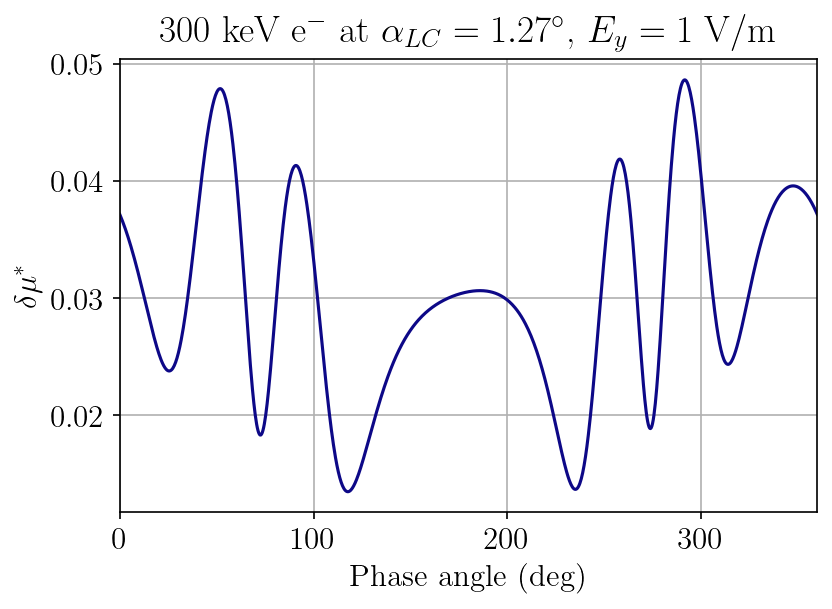

In [33]:
plt.plot(np.degrees(np.linspace(0, 2 * np.pi, 1000)), mu_final - mu_initial)
plt.title(r'$300$ keV e$^-$ at $\alpha_{LC}=1.27^\circ$, $E_y = 1$ V/m')
plt.ylabel(r'$\delta\mu^*$')
plt.xlabel('Phase angle (deg)')
plt.xlim([0, 360])
plt.grid()
plt.show()

In [21]:
dmu = mu_final - mu_initial

In [ ]:
A_numerical = (np.amax(dmu) - np.amin(dmu)) / 2

In [25]:
A_numerical**2

0.0003088843552431371

In [24]:
D_aa_num = A_numerical**2 / (2 * T_alpha(np.radians(1.2716100390783267)) * np.sin(1.2716100390783267)**2 * np.cos(1.2716100390783267)**2)

NameError: name 'T_alpha' is not defined

In [ ]:
1 / D_aa_num

In [ ]:
np.save('300kev_we_dmu', dmu)

In [23]:
a.ke()

array([[ 300000.        ,  300401.2431239 ,  301565.32366853, ...,
         996414.41011992, 1008649.9394183 , 1022030.22652993],
       [ 300000.        ,  300395.32066023,  301554.06895773, ...,
         993047.99602117, 1004859.54068001, 1017932.85786834],
       [ 300000.        ,  300389.4042483 ,  301542.83739108, ...,
         989756.18616867, 1001098.2908787 , 1013820.01084721],
       ...,
       [ 300000.        ,  300413.1052685 ,  301587.90073594, ...,
        1003290.49673874, 1016244.78060263, 1030114.49086771],
       [ 300000.        ,  300407.17140488,  301576.60107704, ...,
         999834.93881151, 1012450.7434184 , 1026095.69245137],
       [ 300000.        ,  300401.2431239 ,  301565.32366853, ...,
         996414.41011992, 1008649.9394183 , 1022030.22652993]])

In [189]:
z2

0.30391151635878794